# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

## Mount Google Drive

In [3]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


## Visual Validation of Overlapping Frames

In [4]:
def visualize_overlapping_frames(title, framed_df, visual_set):
  for i, v in visual_set.items():
    #print( framed_df[framed_df["key"] == v]["max_amp"].idxmax() )
    findex = framed_df[framed_df["key"] == v]["max_amp"].idxmax() - 1
    hop_length = (framed_df.loc[findex]["end"] - framed_df.loc[findex]["start"]) // 2
    print(hop_length)
    frame1 = framed_df.loc[findex]["amp"]
    frame2 = framed_df.loc[findex+1]["amp"]
    frame3 = framed_df.loc[findex+2]["amp"]
    # Plot the overlapping frames
    plt.figure(figsize=(12, 6))

    # Plot first frame
    plt.plot(np.arange(len(frame1)), frame1, label='Frame 1')

    # Plot second frame
    plt.plot(np.arange(hop_length, hop_length + len(frame2)), frame2 + 1, label='Frame 2')

    # Plot third frame
    plt.plot(np.arange(2 * hop_length, 2 * hop_length + len(frame3)), frame3 + 2, label='Frame 3')

    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f'{title} {i} {v}')
    plt.legend()
    plt.show()

def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [256, 512, 1024, 2048]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames

### Test to Validate Reading the Saved File

In [5]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [6]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...","[6.2792744e-12, 1.3262988e-11, 2.1134771e-11, ...",16000,22050,[33600],[46305],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
b9408db9-881b-4a95-ba6c-ac51602955a6,"[5.813955e-10, -7.632952e-10, -1.9169968e-09, ...","[5.454812e-10, -7.5795303e-10, -2.2023776e-09,...",16000,22050,[33600],[46305],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
e9bf0a5a-ff96-480b-a54a-f647143e1d6f,"[6.08183e-09, 3.8103284e-08, 4.4398583e-08, 3....","[-7.584575e-09, -2.4847802e-09, 3.0562568e-08,...",16000,22050,[158400],[218295],"[[2.777657, 3.235886]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
e4729edf-12e5-4ba9-883e-1114c32b90f0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[76800],[105840],"[[1.095201, 1.89583], [2.581275, 3.028796], [3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4c2840ed-fd4b-4a86-b976-5cc040d6ea4e,"[-1.8455714e-06, 2.195019e-06, -2.6295957e-06,...","[8.198129e-08, 1.3033329e-07, -3.5484481e-07, ...",16000,22050,[52800],[72765],"[[1.159085, 1.526838], [1.682357, 2.00403], [2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
48b287c0-5c2b-44ef-b469-3808b3b287ea,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[3.495979, 3.855312], [3.903984, 4.322203], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
52f6838a-4033-4a71-84bb-81cbb4e64ab7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[158400],[218295],"[[1.940096, 2.406454], [2.435831, 2.798757], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7a8bd218-252f-4d84-a035-0d3262efa825,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[159019],[219148],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
type(df_from_save)

pandas.core.frame.DataFrame

### Test to Create Frames and Labels from the Saved File Data

In [8]:
all_frames_from_save = apply_framing(audio_df=df_from_save)

Frame size 256, hop_length 128, count 333215
Frame size 512, hop_length 256, count 166399
Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222


In [9]:
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,0,1024,0.006137,0,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...",0
1,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,512,1536,0.023188,1,"[-0.00024980583, -0.00026363018, -0.0002713691...",0
2,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1024,2048,0.074459,2,"[-0.0018562947, -0.0023917924, -0.0028657983, ...",0
3,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1536,2560,0.074459,3,"[0.0014159846, -0.0015856944, -0.0045660823, -...",0
4,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,2048,3072,0.079874,4,"[0.031991042, 0.025611315, 0.019131511, 0.0129...",0
...,...,...,...,...,...,...,...,...
82952,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,59904,60928,0.021871,117,"[-0.021708837, -0.022235444, -0.021958912, -0....",0
82953,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,60416,61440,0.001310,118,"[0.00046911323, 0.0005246451, 0.00047831138, 0...",0
82954,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,60928,61952,0.000399,119,"[4.2529864e-05, 2.6461403e-05, 3.3375203e-05, ...",0
82955,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,61440,62464,0.000332,120,"[0.0003304775, 0.0003139911, 0.00031356188, 0....",0


In [10]:
visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
visual_set

{'1st': 'b8cda82e-6549-4d43-aad9-8de9bcf8e0e9',
 'Last': '0f8d80f9-700e-4069-924d-e15f29d7c19a'}

512


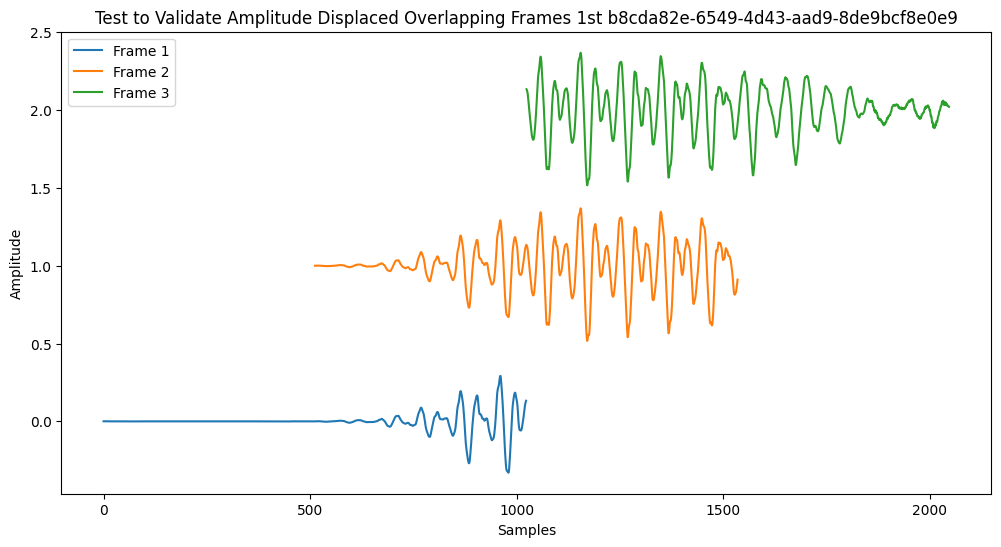

512


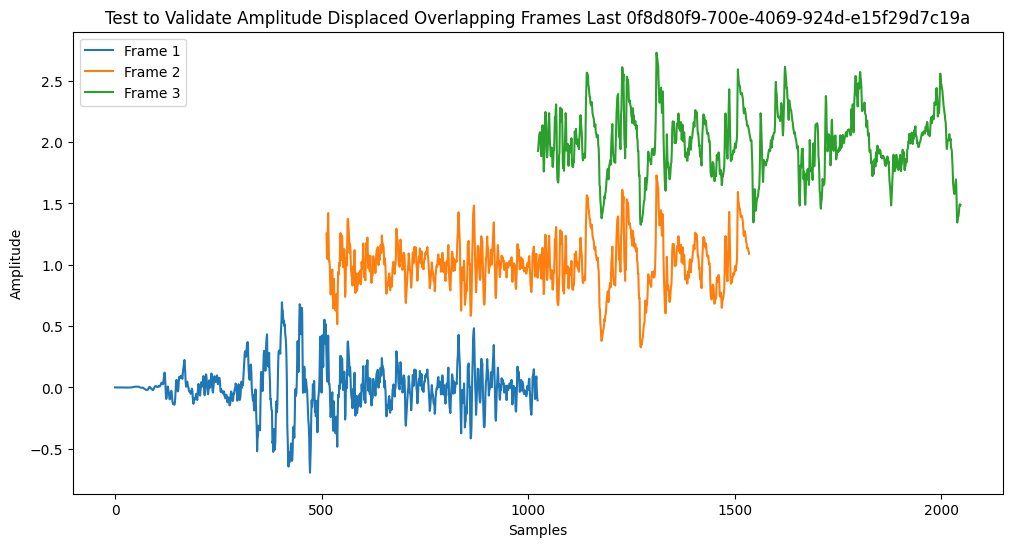

In [11]:
visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction Code

In [12]:
all_frames_from_save[2048]

,key,sf,start,end,max_amp,frame_index,amp,label
0,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,0,2048,0.074459,0,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...",0
1,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1024,3072,0.079874,1,"[-0.0018562947, -0.0023917924, -0.0028657983, ...",0
2,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,2048,4096,0.096461,2,"[0.031991042, 0.025611315, 0.019131511, 0.0129...",0
3,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,3072,5120,0.096461,3,"[0.069244295, 0.074276134, 0.0775114, 0.079172...",0
4,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,4096,6144,0.087525,4,"[0.02599926, 0.029635724, 0.031844947, 0.03335...",0
...,...,...,...,...,...,...,...,...
41217,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,56320,58368,0.333710,55,"[-0.08558691, -0.047807574, -0.04582133, -0.05...",1
41218,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,57344,59392,0.333710,56,"[-0.14765221, -0.10903329, -0.11031698, -0.157...",1
41219,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,58368,60416,0.225726,57,"[0.14180079, 0.15956494, 0.15781122, 0.1761610...",1
41220,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,59392,61440,0.028665,58,"[0.0061827237, 0.011192709, 0.020015003, 0.013...",0


# Your Feature Extraction Code


#Mel-spectrogram code begins here

Below is code that features a function to use the raw audio files (post framing) and create mel-spectrograms from them. The function uses the librosa library to create the mel-spectrograms. The code creates a new dataframe with the new features of the mel-spectrogram and other data about the audio files.
Following the function, there is a CNN used to test model performance using the new dataframe. The CNN after training is saved to the google drive.

In [13]:
import librosa.util as librosa_util
def compute_mel_spectrograms(pd_df_audio_data):
    # Extract audio data and sample rates
    audio_frames = pd_df_audio_data["amp"].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)
    sample_rates = pd_df_audio_data["sf"].values

    # Calculate mel-spectrograms
    mel_spectrograms = []
    mel_shapes = []
    for audio_frame, sr in zip(audio_frames, sample_rates):

        mel = librosa.feature.melspectrogram(y=audio_frame, sr=sr, n_fft=1024, win_length=1024, hop_length=68, n_mels=64)
        mel_db = librosa.power_to_db(mel, ref=np.max(mel))
        mel_spectrograms.append(mel_db)
        mel_shapes.append(mel_db.shape)

    # Create new dataframe for mel-spectrograms
    mel_spec_df = pd.DataFrame({
        "mel": mel_spectrograms,
        "mel_shape": mel_shapes
    }, index=pd_df_audio_data.index)

    # Concatenate additional columns from audio files dataframe
    columns_to_add = ["key", "sf", "start", "end", "max_amp", "frame_index", "amp", "label"]
    mel_spec_df = pd.concat([mel_spec_df, pd_df_audio_data[columns_to_add]], axis=1)

    return mel_spec_df

In [14]:
# Compute mel-spectrograms using data after framing
audio_df_with_mel_spectrograms = compute_mel_spectrograms(all_frames_from_save[1024])

In [15]:
# Check that dataframe was created
audio_df_with_mel_spectrograms.head()

,mel,mel_shape,key,sf,start,end,max_amp,frame_index,amp,label
0,"[[-49.471313, -45.68248, -42.952454, -41.20059...","(64, 16)",b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,0,1024,0.006137,0,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...",0
1,"[[-49.61094, -48.172184, -47.08938, -44.50936,...","(64, 16)",b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,512,1536,0.023188,1,"[-0.00024980583, -0.00026363018, -0.0002713691...",0
2,"[[-38.306217, -38.219006, -38.82951, -39.85528...","(64, 16)",b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1024,2048,0.074459,2,"[-0.0018562947, -0.0023917924, -0.0028657983, ...",0
3,"[[-26.36286, -26.713167, -27.691568, -29.2802,...","(64, 16)",b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1536,2560,0.074459,3,"[0.0014159846, -0.0015856944, -0.0045660823, -...",0
4,"[[-20.302574, -20.074223, -20.54555, -21.73757...","(64, 16)",b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,2048,3072,0.079874,4,"[0.031991042, 0.025611315, 0.019131511, 0.0129...",0


Preview visual representation of the melspectrogram

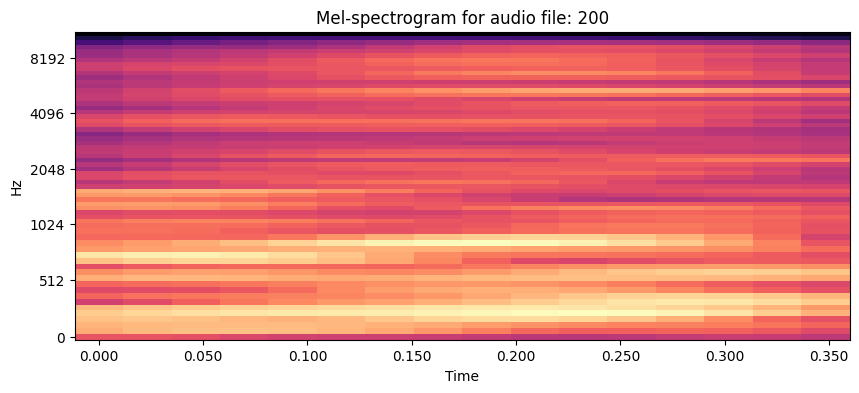

In [16]:
# Display mel-spectrogram for a sample audio file
sample_index = 200
fig, ax = plt.subplots(figsize=(10, 4))
mel_spec = audio_df_with_mel_spectrograms.loc[audio_df_with_mel_spectrograms.index[sample_index], "mel"]
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', ax=ax)
ax.set_title(f'Mel-spectrogram for audio file: {audio_df_with_mel_spectrograms.index[sample_index]}')
plt.show()

In [17]:
!pip install imbalanced-learn

#CNN
code to run the model

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

# Bring in mel-spectrogram from dataframe created above, put it in expected size
mel_spectrograms = np.array([mel_spec.reshape(64, 16, 1) for mel_spec in audio_df_with_mel_spectrograms['mel']])
# Bring in labels (cough (1) vs non-cough (0))
labels = np.array(audio_df_with_mel_spectrograms['label'])

# Define the model architecture
def cough_detection_model(input_shape):
    """
    Creates a CNN model for cough detection.

    Args:
        input_shape: A tuple representing the shape of the input data (e.g., (64, 16, 1)).

    Returns:
        A compiled Keras model.
    """

    # Input layer
    inputs = keras.Input(shape=input_shape)

    # First convolutional layer
    x = layers.Conv2D(16, kernel_size=(9, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Second convolutional layer
    x = layers.Conv2D(16, kernel_size=(5, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Flatten the output of convolutional layers
    x = layers.Flatten()(x)

    # First fully-connected layer with dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # Dropout with probability 0.5

    # Second fully-connected layer with dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # Dropout with probability 0.5

    # Output layer with softmax activation
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer,
        metrics=[
                "accuracy",
                metrics.Precision(name='precision'),
                metrics.Recall(name='recall'),
                metrics.AUC(name='auc_roc', curve='ROC'),
                metrics.AUC(name='auc_pr', curve='PR'),
                metrics.TruePositives(name='true_positives'),
                metrics.FalsePositives(name='false_positives'),
                metrics.TrueNegatives(name='true_negatives'),
                metrics.FalseNegatives(name='false_negatives'),
                metrics.FBetaScore(name='f1_score', beta=1.0)
    ])

    return model

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Implementing k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Placeholder for metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []
auc_pr_scores = []

# Split into train and validation sets
for train_index, val_index in skf.split(mel_spectrograms, labels):
    X_train, X_val = mel_spectrograms[train_index], mel_spectrograms[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Apply SMOTE for oversampling the minority class in training data
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    smote = SMOTE()
    X_train_resampled_2d, y_train_resampled = smote.fit_resample(X_train_2d, y_train)

    # Reshape the oversampled training data back to 3D
    X_train_resampled = X_train_resampled_2d.reshape(-1, 64, 16, 1)

    # Apply SMOTE for oversampling the minority class in validation data
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    X_val_resampled_2d, y_val_resampled = smote.fit_resample(X_val_2d, y_val)

    # Reshape the oversampled validation data back to 3D
    X_val_resampled = X_val_resampled_2d.reshape(-1, 64, 16, 1)

    # Convert labels to float32
    #X_train_resampled = X_train_resampled.astype('float32')
    #X_val = X_val.astype('float32')
    y_train_resampled = y_train_resampled.astype('float32')
    y_val = y_val.astype('float32')

    # Define input shape
    model = cough_detection_model(input_shape=(64, 16, 1))
    #model.summary()

    # Fit the model
    model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_val)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy_scores.append(accuracy_score(y_val, y_pred_classes))
    precision_scores.append(precision_score(y_val, y_pred_classes))
    recall_scores.append(recall_score(y_val, y_pred_classes))
    f1_scores.append(f1_score(y_val, y_pred_classes))
    auc_roc_scores.append(model.evaluate(X_val, y_val, verbose=0)[4])
    auc_pr_scores.append(model.evaluate(X_val, y_val, verbose=0)[5])

    # Print confusion matrix for current fold
    cm = confusion_matrix(y_val, y_pred_classes)
    print("Confusion Matrix for current fold:")
    print(cm)


# Save the trained model
# Define the desired path
desired_path = f'/content/drive/My Drive/{GDRIVE_DATA_DIR}'

# Construct the full file path
model_path = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}/cnn_model_melspectrogram.h5"

# Create the directory if it doesn't exist
os.makedirs(desired_path, exist_ok=True)

# Save model
model.save(model_path)
print(f"Model saved to '{model_path}'")



Class weights: {0: 0.559273242095328, 1: 4.717754777070064}
Epoch 1/10
 742/3709 [=====>........................] - ETA: 2:36 - loss: 0.6600 - accuracy: 0.6783 - precision: 0.6633 - recall: 0.7154 - auc_roc: 0.7371 - auc_pr: 0.6935 - true_positives: 8437.0000 - false_positives: 4282.0000 - true_negatives: 7668.0000 - false_negatives: 3357.0000 - f1_score: 0.6638

Code to call saved CNN

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/My Drive/23-24_CE903-SU_team06/dataset/cnn_model_melspectrogram.h5')